<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/student_pgmpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The (simplified) student Bayes net

This model is from https://github.com/pgmpy/pgmpy_notebook/blob/master/notebooks/2.%20Bayesian%20Networks.ipynb

In [1]:
!pip install  causalgraphicalmodels
!pip install pgmpy



     |████████████████████████████████| 337kB 7.7MB/s 


In [7]:
from causalgraphicalmodels import CausalGraphicalModel
import pgmpy
import numpy as np
import pandas as pd

# Model

In [2]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

# The representation of CPD in pgmpy is a bit different than the CPD shown in the above picture. In pgmpy the colums
# are the evidences and rows are the states of the variable. So the grade CPD is represented like this:
#
#    +---------+---------+---------+---------+---------+
#    | diff    | intel_0 | intel_0 | intel_1 | intel_1 |
#    +---------+---------+---------+---------+---------+
#    | intel   | diff_0  | diff_1  | diff_0  | diff_1  |
#    +---------+---------+---------+---------+---------+
#    | grade_0 | 0.3     | 0.05    | 0.9     | 0.5     |
#    +---------+---------+---------+---------+---------+
#    | grade_1 | 0.4     | 0.25    | 0.08    | 0.3     |
#    +---------+---------+---------+---------+---------+
#    | grade_2 | 0.3     | 0.7     | 0.02    | 0.2     |
#    +---------+---------+---------+---------+---------+

cpd_g = TabularCPD(variable='G', variable_card=3, 
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])

cpd_l = TabularCPD(variable='L', variable_card=2, 
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])

cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])

# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly 
# defined and sum to 1.
model.check_model()

True

In [3]:
# CPDs can also be defined using the state names of the variables. If the state names are not provided
# like in the previous example, pgmpy will automatically assign names as: 0, 1, 2, ....

cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3, 
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2, 
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

In [5]:
 #Printing a CPD with it's state names defined.
print(model.get_cpds('G'))

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


# Visualization

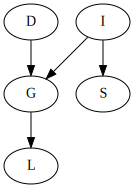

'Digraph.gv.pdf'

In [8]:
model2 = CausalGraphicalModel(nodes = model.nodes(), edges=model.edges())

out = model2.draw()
display(out)
out.render()

# Inference

In [11]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)


## Posterior given Grade=C

In [19]:
evidence = {'G': 'C'}
postD = infer.query(['D'],  evidence=evidence).values
postI = infer.query(['I'],  evidence=evidence).values

print('\n')
print('Pr(Difficulty=Hard|Grade=C) = {:0.2f}'.format(postD[1]))
print('Pr(Intelligent=High|Grade=C) = {:0.2f}'.format(postI[1]))

Eliminating: S: 100%|██████████| 3/3 [00:00<00:00, 334.85it/s]



Pr(Difficulty=Hard|Grade=C) = 0.63
Pr(Intelligent=High|Grade=C) = 0.08


## Posterior given Grade=C, SAT=Good

In [20]:
evidence = {'G': 'C', 'S': 'Good'}
postD = infer.query(['D'],  evidence=evidence).values
postI = infer.query(['I'],  evidence=evidence).values

print('\n')
print('Pr(Difficulty=Hard|Grade=C,SAT=Good) = {:0.2f}'.format(postD[1]))
print('Pr(Intelligent=High|Grade=C,SAT=Good) = {:0.2f}'.format(postI[1]))

Eliminating: L: 100%|██████████| 2/2 [00:00<00:00, 348.62it/s]



Pr(Difficulty=Hard|Grade=C,SAT=Good) = 0.76
Pr(Intelligent=High|Grade=C,SAT=Good) = 0.58
